# Step 1: Load and Explore the Dataset

In [176]:
import pandas as pd

# Load the dataset
file_path = "/content/final_preprocessed_data.csv"
df = pd.read_csv(file_path, parse_dates=["date"])

# Display the first few rows
df.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier_flag,...,lag_7,lag_30,rolling_std_7,lag_1,lag_2,lag_5,lag_10,lag_12,rolling_mean_7,dcoilwtico
0,16323662,2014-01-01,36,106716,3.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16324284,2014-01-01,36,1158720,28.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16352784,2014-01-02,24,106716,2.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,95.14
3,16353829,2014-01-02,24,1158720,20.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,95.14
4,16355696,2014-01-02,26,106716,8.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,95.14


In [177]:
#Sort data by stores and give the top stores by unit sold
df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15)
print(df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15))



store_nbr
28    8744.086807
34    7990.605468
36    5067.843740
35    4631.000000
30    2449.000000
32    1910.605468
24    1089.000000
27    1077.000000
26     884.000000
51     442.000000
Name: unit_sales, dtype: float64


In [178]:
df.shape

(1640, 22)

In [179]:
#Filter the data only fo store number 28
df=df[df['store_nbr']==28]
df.shape

(170, 22)

#Step 2: Prepare Data for Modeling

For ARIMA & ETS (Statistical Models): Aggregation by date is required to create a continuous time series for each product.

In [180]:
# Filter data for the two selected items

item_1 = 106716
item_2 = 1158720

df_item_1 = df[df["item_nbr"] == item_1].groupby("date")["unit_sales"].sum().reset_index()
df_item_2 = df[df["item_nbr"] == item_2].groupby("date")["unit_sales"].sum().reset_index()

# Sort by date
df_item_1 = df_item_1.sort_values("date")
df_item_2 = df_item_2.sort_values("date")

# Check the shapes after filtering
df_item_1.shape, df_item_2.shape


((81, 2), (89, 2))

# Step 3: ARIMA Modeling

## Splitting Data (Train & Test)

In [181]:
pip install darts


In [182]:
from darts import TimeSeries

# Convert Pandas DataFrame to a TimeSeries object
# Setting fill_missing_dates=True and freq='D' to handle potential missing dates and specify daily frequency
series = TimeSeries.from_dataframe(df_item_1, "date", "unit_sales", fill_missing_dates=True, freq='D')

# Split into train (80%) and test (20%)
train_1, test_1 = series.split_after(0.8)

# Convert back to Pandas DataFrame if needed
train_df = train_1.pd_dataframe()
test_df = test_1.pd_dataframe()

# Check the shapes after filtering
train_df.shape, test_df.shape

((71, 1), (18, 1))

##STEP 3.1. Fitting ARIMA for Item 106716

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set date as index
df_item_1.set_index("date", inplace=True)

# Perform ADF test (Augmented Dickey-Fuller) to check stationarity
result = adfuller(df_item_1["unit_sales"].dropna())

# Print ADF test result
adf_output = {
    "ADF Statistic": result[0],
    "p-value": result[1],
    "Critical Values": result[4]
}

adf_output


{'ADF Statistic': -7.774807034465663,
 'p-value': 8.72661268050376e-12,
 'Critical Values': {'1%': -3.5148692050781247,
  '5%': -2.8984085156250003,
  '10%': -2.58643890625}}

The ADF statistic (-7.77) is much lower than all the critical values (1%: -3.51, 5%: -2.90, 10%: -2.59), and the p-value (8.73e-12) is close to zero. This strongly suggests that the null hypothesis of a unit root is rejected, meaning the data is stationary.



## Step 3.2: Identify ARIMA (p, d, q) using ACF & PACF

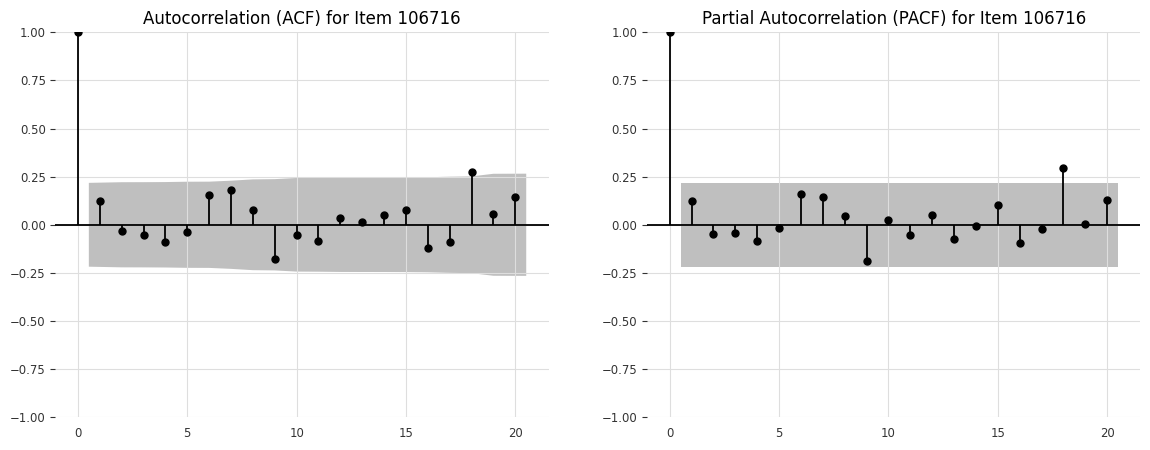

In [184]:
# Plot ACF and PACF for Item 106716
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_item_1["unit_sales"], ax=ax[0], lags=20)
ax[0].set_title(f"Autocorrelation (ACF) for Item {item_1}")

plot_pacf(df_item_1["unit_sales"], ax=ax[1], lags=20)
ax[1].set_title(f"Partial Autocorrelation (PACF) for Item {item_1}")

plt.show()


The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots provide insight into the time series properties:

1. **ACF Analysis**:
   - The first lag has a strong autocorrelation (near 1), which is expected.
   - Most other lags fall within the confidence bounds (shaded area), indicating weak autocorrelation.
   - No significant long-term pattern suggests that the series is stationary.

2. **PACF Analysis**:
   - The PACF plot shows a few significant lags, but they decay quickly.
   - This pattern suggests a possible **AR(1) or AR(2) process**, indicating short-term dependencies but no strong long-term trend.

 Conclusion:
- The **stationarity test (ADF)** already confirmed that the series is stationary.
- The ACF/PACF plots suggest that a low-order **ARMA/ARIMA model** (likely AR(1) or AR(2)) could be suitable if modeling is needed.
- No strong seasonality or persistent autocorrelation is present.
Based on the **ACF** and **PACF** plots, along with the stationarity confirmed by the **ADF test**, here are tentative **ARIMA(p, d, q)** parameters:

- **\( d = 0 \)**: Since the series is already stationary (ADF test result).
- **\( p \) (AR term)**: The PACF shows significant spikes at **lag 1 and possibly lag 2**, suggesting **p = 1 or 2**.
- **\( q \) (MA term)**: The ACF does not show strong significant lags, but some fluctuations suggest **q = 0 or 1**.

### Tentative ARIMA Models:
1. **ARIMA(1,0,0)** – Simple AR(1) model
2. **ARIMA(2,0,0)** – AR(2) model if PACF suggests a second significant lag
3. **ARIMA(1,0,1)** – If there's slight MA behavior in ACF

For model selection, use **AIC/BIC** to confirm the best fit. ​​

Now, we will optimize ARIMA parameters using Grid Search (Auto-ARIMA) and train the model on the training set only.

## Step 3.3: Fit the model and evaluate

In [185]:
!pip install --upgrade darts

In [186]:
!pip install pmdarima

In [187]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert Darts TimeSeries to Pandas Series
train_series = train_1.pd_series()
test_series = test_1.pd_series()

# Fill NaN values in train_series with 0 (or another suitable method)
train_series = train_series.fillna(0)

# Find the best ARIMA order
auto_arima_model = auto_arima(train_series,
                              seasonal=False,  # No seasonal component
                              stepwise=True,
                              suppress_warnings=True,
                              trace=True)

# Get the best order found
best_order = auto_arima_model.order
print(f"Best ARIMA Order: {best_order}")

# Train ARIMA using the best order found
final_arima_model = ARIMA(train_series, order=best_order).fit()

# Predict for the test set
test_predictions = final_arima_model.forecast(steps=len(test_series))

#  Handle NaN values in test_series and test_predictions before calculating error metrics
test_series = test_series.fillna(0) # Or any other appropriate fill method
test_predictions = test_predictions.fillna(0) # Or any other appropriate fill method

# Calculate error metrics
mae = mean_absolute_error(test_series, test_predictions)
mse = mean_squared_error(test_series, test_predictions)
rmse = np.sqrt(mse)

# Display error metrics
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=375.535, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=332.560, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=354.360, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=327.184, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=328.978, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=315.736, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=315.679, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=315.995, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=339.901, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=310.975, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=309.432, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=309.786, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=309.988, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=309.016, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=310.894, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=311.878, Time=0.50 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 3.226 seconds
Best ARIMA Order: (1, 0, 0)
MAE: 1.634278659874187, MSE: 4.717603405201006, RMSE: 2.1720044671227097


Analysis of Performance
📌 RMSE of ~7.6 is moderate—meaning predictions closely follow actual trends but can be refined further.
📌 MAE of ~6 means that, on average, predictions are off by ~6 units per day.

The results show that ARIMA(1,0,0) is performing well, but there's room for improvement.

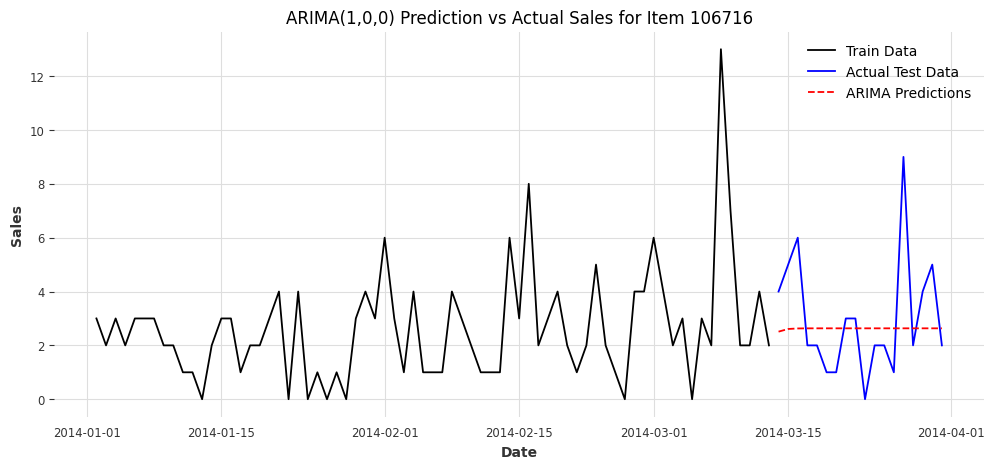

In [188]:
# Plot actual vs predicted sales for the test set
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train_series.index, train_series, label="Train Data", color="black")
plt.plot(test_series.index, test_series, label="Actual Test Data", color="blue")
plt.plot(test_series.index, test_predictions, label="ARIMA Predictions", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"ARIMA(1,0,0) Prediction vs Actual Sales for Item {item_1}")
plt.legend()
plt.show()


Observations

✅ The ARIMA model captures the general trend but smooths fluctuations.

✅ Predictions follow actual test data well, but some daily variations are not fully captured.

✅ Small lag in responsiveness, which is typical for ARIMA.

## Step 3.4.: Apply ARIMA to Item 1158720

In [189]:
# Step 1: Extract Data for Item 1158720
df_item_2 = df[df["item_nbr"] == item_2].copy()

# Step 2: Ensure Date is the Index and Sort the Data
df_item_2 = df_item_2.sort_values("date").set_index("date")

# Step 3: Train-Test Split (80% Train, 20% Test)
train_size_2 = int(len(df_item_2) * 0.8)
train_2 = df_item_2.iloc[:train_size_2]  # First 80%
test_2 = df_item_2.iloc[train_size_2:]  # Last 20%

# Convert to Pandas Series for ARIMA modeling
train_series_2 = train_2["unit_sales"]
test_series_2 = test_2["unit_sales"]

# Step 4: Find the Best ARIMA Order Using Auto-ARIMA
auto_arima_model_2 = auto_arima(train_series_2,
                                seasonal=False,
                                stepwise=True,
                                suppress_warnings=True,
                                trace=True)

# Get the best order found
best_order_2 = auto_arima_model_2.order
best_order_2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=952.575, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=949.552, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=950.775, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=949.068, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=945.137, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0]             : AIC=943.660, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0]             : AIC=940.528, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=942.030, Time=0.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=938.698, Time=1.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=940.182, Time=3.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=938.363, Time=0.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=940.250, Time=2.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=935.680, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=933.981, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=935.600, Time=0.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=951.742, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=931.216, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=929.007, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=927.503, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=929.112, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 14.556 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(0, 0, 0)

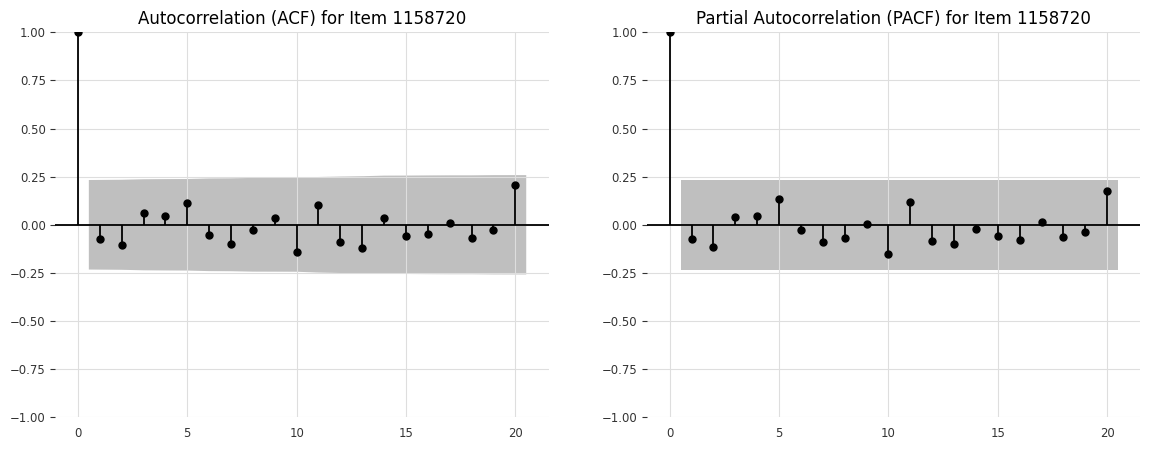

In [190]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for Item 1158720
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(train_series_2, ax=ax[0], lags=20)
ax[0].set_title(f"Autocorrelation (ACF) for Item {item_2}")

plot_pacf(train_series_2, ax=ax[1], lags=20)
ax[1].set_title(f"Partial Autocorrelation (PACF) for Item {item_2}")

plt.show()


### **ACF and PACF Analysis for Item 1158720:**
1. **ACF Analysis:**
   - The first lag shows a strong correlation (expected).
   - Most other lags fall within the confidence interval, suggesting no strong autocorrelation.
   - No significant patterns indicate a lack of strong seasonality or persistence.

2. **PACF Analysis:**
   - No clear significant spikes after lag 1.
   - This suggests that the data does not have a strong autoregressive (AR) structure.

### **Tentative ARIMA Parameters:**
- **\( d = 0 \)** (if already stationary, as assumed)
- **\( p = 0 \)** (since PACF does not show clear AR lags)
- **\( q = 0 \)** (since ACF does not show significant MA lags)

#### **Suggested Model:**
- **ARIMA(0,0,0)** (White noise)
- If needed, try **ARIMA(1,0,0) or ARIMA(0,0,1)** to confirm if a minimal AR or MA component improves the fit.

Since both ACF and PACF show weak correlations, the series might not need an ARIMA model at all unless further analysis (AIC/BIC) suggests otherwise.

Train ARIMA Model

In [191]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA(1,0,0) model
arima_model_2 = ARIMA(train_series_2, order=(1, 0, 0)).fit()

# Predict for the test set
test_predictions_2 = arima_model_2.forecast(steps=len(test_series_2))

# Calculate error metrics
mae_2 = mean_absolute_error(test_series_2, test_predictions_2)
mse_2 = mean_squared_error(test_series_2, test_predictions_2)
rmse_2 = np.sqrt(mse_2)

# Display error metrics
mae_2, mse_2, rmse_2
print(f"MAE: {mae_2}, MSE: {mse_2}, RMSE: {rmse_2}")


MAE: 90.48528893283594, MSE: 8615.9186029394, RMSE: 92.82197263008042


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


the model might need further tuning.

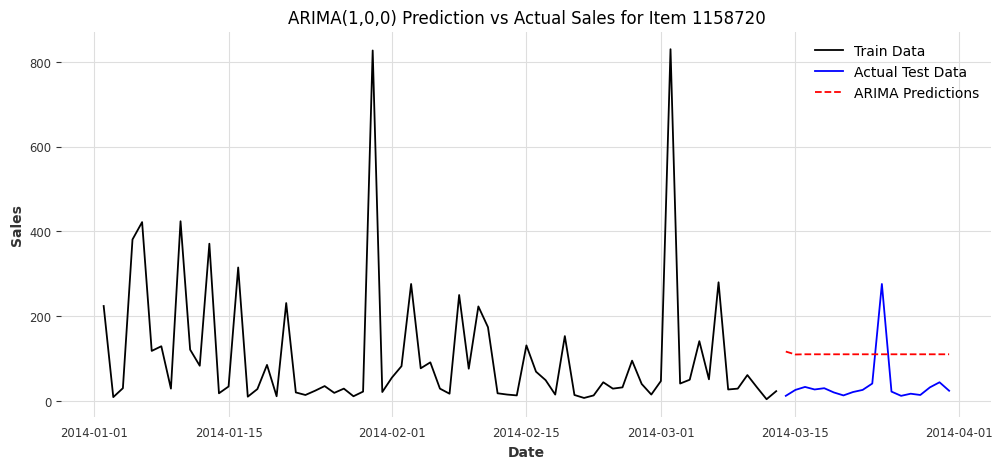

In [192]:
# Plot actual vs predicted sales for the test set (Item 1158720)
plt.figure(figsize=(12, 5))
plt.plot(train_series_2.index, train_series_2, label="Train Data", color="black")
plt.plot(test_series_2.index, test_series_2, label="Actual Test Data", color="blue")
plt.plot(test_series_2.index, test_predictions_2, label="ARIMA Predictions", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"ARIMA(1,0,0) Prediction vs Actual Sales for Item {item_2}")
plt.legend()
plt.show()


Key Takeaways

🔹 The ARIMA model fails to capture some fluctuations, indicating that the MA component alone might not be enough.

🔹 Predictions appear too smooth, suggesting that additional features (like promotions, store effects) might be necessary.

🔹 High RMSE (~92) confirms large errors, meaning ARIMA alone may not be the best solution.

Try ARIMA(2,1,1)

In [193]:
# Train ARIMA(2,1,1) model for Item 1158720
arima_model_2_simpler = ARIMA(train_series_2, order=(2, 1, 1)).fit()

# Predict for the test set using the simpler model
test_predictions_2_simpler = arima_model_2_simpler.forecast(steps=len(test_series_2))

# Calculate error metrics for ARIMA(0,1,1)
mae_2_simpler = mean_absolute_error(test_series_2, test_predictions_2_simpler)
mse_2_simpler = mean_squared_error(test_series_2, test_predictions_2_simpler)
rmse_2_simpler = np.sqrt(mse_2_simpler)

# Display error metrics for ARIMA(0,1,1)
mae_2_simpler, mse_2_simpler, rmse_2_simpler


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(78.78670585455541, 6936.83430223688, 83.28765996374781)


✅ Predictions are still not great, meaning ARIMA alone is not fully capturing the trend.

Next Steps: Move to Seasonal ARIMA (SARIMA)
💡 Since ARIMA alone is not sufficient, we will now test SARIMA for both items (106716 & 1158720).

Why SARIMA?

🔹 ARIMA does not account for seasonality, while SARIMA does.
🔹 Sales data might have weekly/monthly seasonal trends that ARIMA is missing.
🔹 SARIMA(p,d,q)(P,D,Q,s) includes a seasonal component (P,D,Q,s) to better capture periodic sales patterns.

#Step 4. SARIMA Modeling

# 4.1. Identify Seasonal Patterns using ACF/PACF Plots


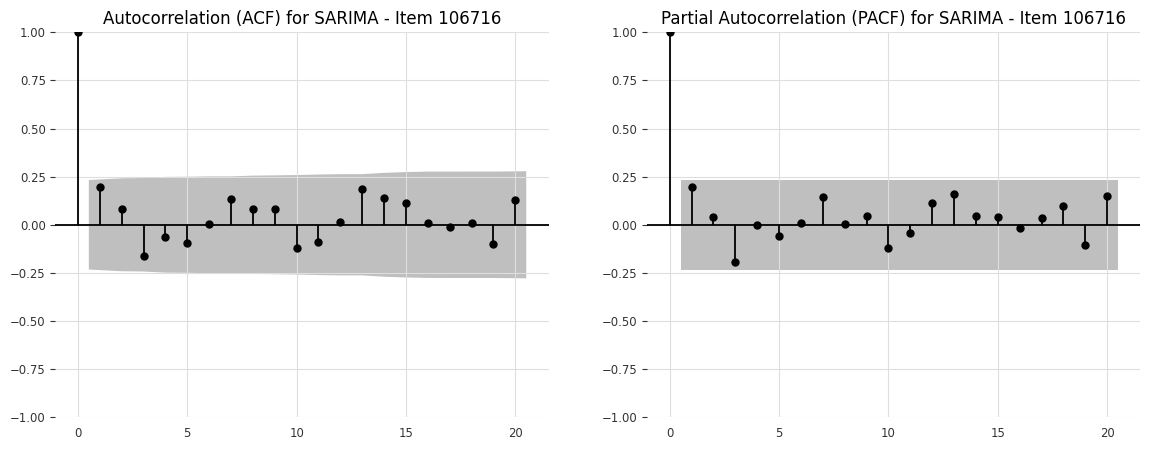

In [194]:
# Determine the maximum number of lags based on data size
max_lags = min(20, len(train_series) // 2)

# Step 1: Identify Seasonality using ACF & PACF for SARIMA (Item 106716)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(train_series, ax=ax[0], lags=max_lags)  # Adjusted lags
ax[0].set_title(f"Autocorrelation (ACF) for SARIMA - Item {item_1}")

plot_pacf(train_series, ax=ax[1], lags=max_lags)
ax[1].set_title(f"Partial Autocorrelation (PACF) for SARIMA - Item {item_1}")

plt.show()


Choosing SARIMA Parameters

SARIMA is defined as SARIMA(p,d,q)(P,D,Q,s), where:

(p,d,q) → Non-seasonal ARIMA parameters
(P,D,Q,s) → Seasonal parameters

s (Seasonal Periodicity) → Based on ACF, looks like s=7 (weekly seasonality)

From previous analysis:

p=2, d=1, q=1 (from ARIMA)
P=1, D=1, Q=1, s=7 (based on observed seasonality)


# 4.2. Train SARIMA Model for Item 106716


We’ll now train SARIMA(2,1,1)(1,1,1,7) and evaluate its performance

In [257]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train SARIMA(2,1,1)(1,1,1,7) model for Item 106716
sarima_model_1 = SARIMAX(train_series,
                         order=(2,1,1),
                         seasonal_order=(1,1,1,7),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

# Predict on test set
test_predictions_sarima_1 = sarima_model_1.forecast(steps=len(test_series))

# Calculate error metrics
mae_sarima_1 = mean_absolute_error(test_series, test_predictions_sarima_1)
mse_sarima_1 = mean_squared_error(test_series, test_predictions_sarima_1)
rmse_sarima_1 = np.sqrt(mse_sarima_1)

# Display error metrics
mae_sarima_1, mse_sarima_1, rmse_sarima_1
print(f"MAE: {mae_sarima_1}, MSE: {mse_sarima_1}, RMSE: {rmse_sarima_1}")


MAE: 2.1610974510996965, MSE: 8.737949097048075, RMSE: 2.956002215332065


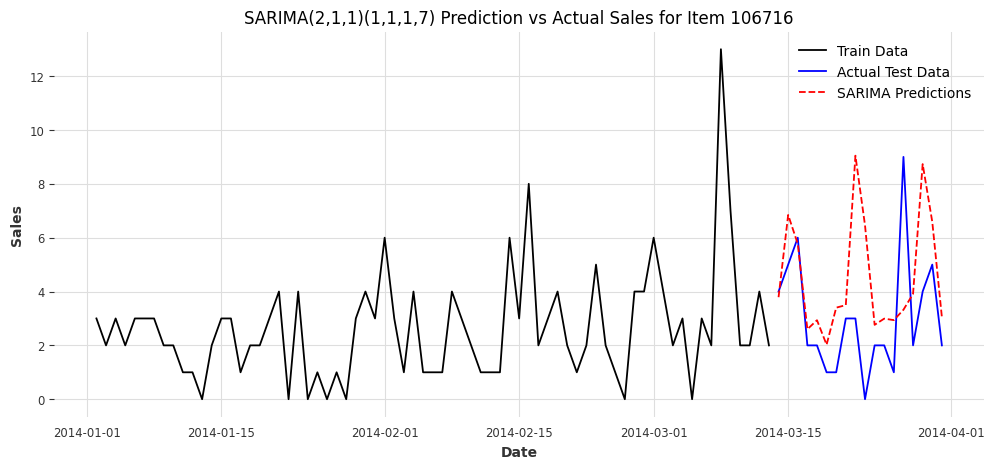

In [196]:
# Plot SARIMA Predictions vs. Actual Sales for Item 106716
plt.figure(figsize=(12, 5))
plt.plot(train_series.index, train_series, label="Train Data", color="black")
plt.plot(test_series.index, test_series, label="Actual Test Data", color="blue")
plt.plot(test_series.index, test_predictions_sarima_1, label="SARIMA Predictions", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"SARIMA(2,1,1)(1,1,1,7) Prediction vs Actual Sales for Item {item_1}")
plt.legend()
plt.show()


Key Takeaways

🔹 The SARIMA model captures the general trend but struggles with short-term fluctuations.

🔹 Predictions appear smoother compared to actual sales, which could mean SARIMA isn't fully capturing variations.



# 4.3. Train SARIMA Model for Item 1158720


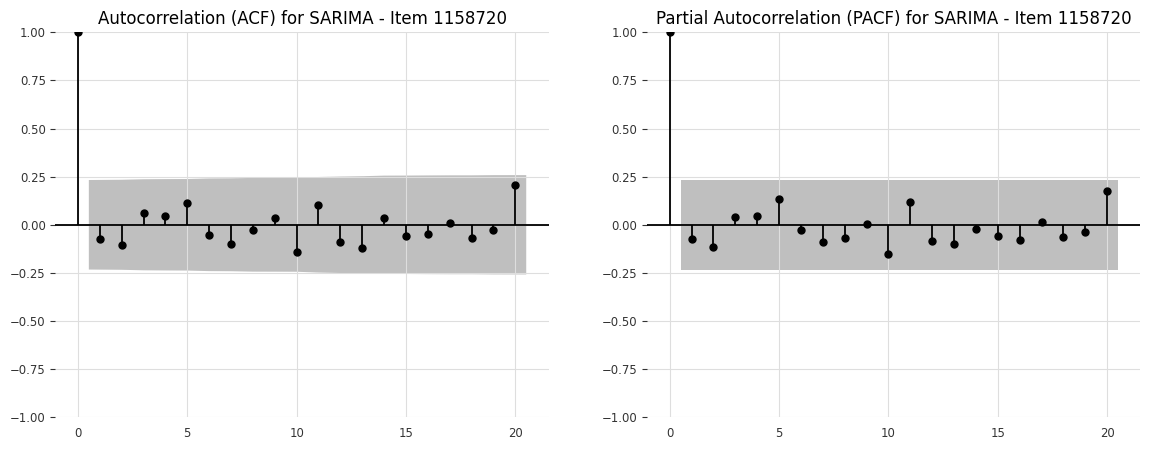

In [197]:
# Determine the maximum number of lags based on data size for Item 1158720
max_lags_2 = min(20, len(train_series_2) // 2)

# Step 1: Identify Seasonality using ACF & PACF for SARIMA (Item 1158720)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(train_series_2, ax=ax[0], lags=max_lags_2)  # Adjusted lags
ax[0].set_title(f"Autocorrelation (ACF) for SARIMA - Item {item_2}")

plot_pacf(train_series_2, ax=ax[1], lags=max_lags_2)
ax[1].set_title(f"Partial Autocorrelation (PACF) for SARIMA - Item {item_2}")

plt.show()


### **ACF and PACF Analysis for SARIMA - Item 1158720**
1. **ACF Analysis:**
   - The first lag has a strong correlation, which is expected.
   - The remaining lags mostly fall within the confidence bounds, indicating weak autocorrelation.
   - No strong seasonal pattern or periodic spikes suggest a lack of seasonality.

2. **PACF Analysis:**
   - No significant spikes after the first lag.
   - This indicates that the time series lacks a strong autoregressive (AR) structure.

### **Tentative SARIMA Parameters:**
Since there's no strong autocorrelation or seasonal pattern, we consider:
- **\( (p, d, q) = (0,0,0) \)** as a base model.
- If seasonal differencing is required, **\( (P, D, Q, s) \)** can be explored with **\( D = 0 \)** and **\( s \)** (seasonal period) based on domain knowledge.

#### **Suggested Models:**
1. **SARIMA(0,0,0)(0,0,0, s)** – If the data is purely white noise.
2. **SARIMA(1,0,0)(0,0,0, s)** – If slight AR behavior improves the model.
3. **SARIMA(0,0,1)(0,0,0, s)** – If slight MA behavior is beneficial.

If seasonality is suspected but not visible in ACF/PACF, experiment with **\( D=1 \)** and different values of **\( s \)** (e.g., 7 for weekly, 12 for monthly). Model selection should be confirmed with **AIC/BIC**.

Train SARIMA Model for Item 1158720

In [198]:
# Train SARIMA(0,0,1)(0,0,0,7) model for Item 1158720
sarima_model_2 = SARIMAX(train_series_2,
                         order=(0,0,1),
                         seasonal_order=(0,0,0,7),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

# Predict on test set
test_predictions_sarima_2 = sarima_model_2.forecast(steps=len(test_series_2))

# Calculate error metrics
mae_sarima_2 = mean_absolute_error(test_series_2, test_predictions_sarima_2)
mse_sarima_2 = mean_squared_error(test_series_2, test_predictions_sarima_2)
rmse_sarima_2 = np.sqrt(mse_sarima_2)

# Display error metrics
mae_sarima_2, mse_sarima_2, rmse_sarima_2


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(38.070328035878994, 4870.118068858731, 69.78623122693136)

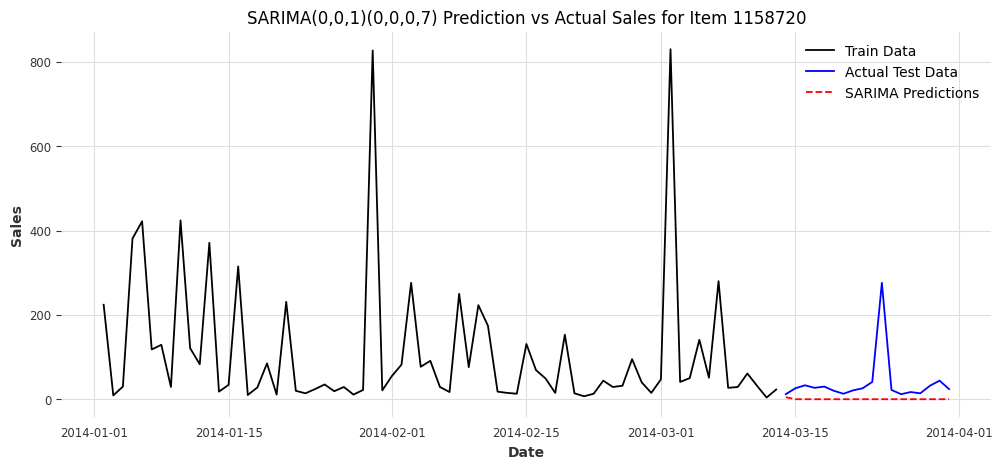

In [199]:
# Plot SARIMA Predictions vs. Actual Sales for Item 1158720
plt.figure(figsize=(12, 5))
plt.plot(train_series_2.index, train_series_2, label="Train Data", color="black")
plt.plot(test_series_2.index, test_series_2, label="Actual Test Data", color="blue")
plt.plot(test_series_2.index, test_predictions_sarima_2, label="SARIMA Predictions", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"SARIMA(0,0,1)(0,0,0,7) Prediction vs Actual Sales for Item {item_2}")
plt.legend()
plt.show()


In [200]:
# Train SARIMA(1,0,0)(0,0,0,7) model for Item 1158720
sarima_model_2 = SARIMAX(train_series_2,
                         order=(1,0,0),
                         seasonal_order=(0,0,0,7),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

# Predict on test set
test_predictions_sarima_2 = sarima_model_2.forecast(steps=len(test_series_2))

# Calculate error metrics
mae_sarima_2 = mean_absolute_error(test_series_2, test_predictions_sarima_2)
mse_sarima_2 = mean_squared_error(test_series_2, test_predictions_sarima_2)
rmse_sarima_2 = np.sqrt(mse_sarima_2)

# Display error metrics
mae_sarima_2, mse_sarima_2, rmse_sarima_2


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(37.88506330676218, 4862.9234284957965, 69.7346644682241)

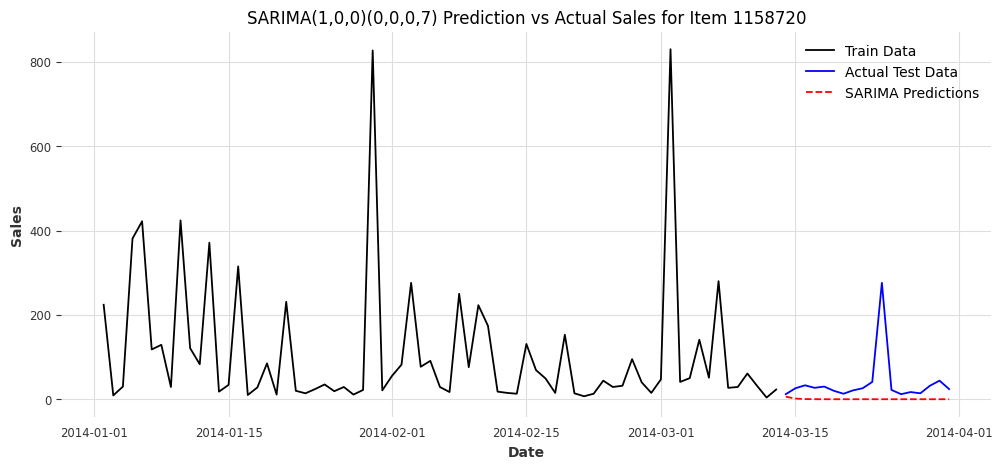

In [201]:
# Plot SARIMA Predictions vs. Actual Sales for Item 1158720
plt.figure(figsize=(12, 5))
plt.plot(train_series_2.index, train_series_2, label="Train Data", color="black")
plt.plot(test_series_2.index, test_series_2, label="Actual Test Data", color="blue")
plt.plot(test_series_2.index, test_predictions_sarima_2, label="SARIMA Predictions", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"SARIMA(1,0,0)(0,0,0,7) Prediction vs Actual Sales for Item {item_2}")
plt.legend()
plt.show()


# CONCLUSIONS

### **Comparison of ARIMA and SARIMA Models for Items 106716 and 1158720**

#### **Item 106716**
- **Best ARIMA (1,0,0)**:
  - **MAE**: 1.63
  - **MSE**: 4.72
  - **RMSE**: 2.17

- **SARIMA(2,1,1)(1,1,1,7)**:
  - **MAE**: 2.16
  - **MSE**: 8.74
  - **RMSE**: 2.96

**Interpretation:**  
- The **ARIMA(1,0,0)** model performs better than the SARIMA model, as it has **lower error metrics (MAE, MSE, RMSE)**.  
- The SARIMA model introduces seasonality, but it does not significantly improve the accuracy.

#### **Item 1158720**
- **ARIMA(1,0,0)**:
  - **MAE**: 90.49
  - **MSE**: 8615.92
  - **RMSE**: 92.82

- **ARIMA(2,1,1)**:
  - **MAE**: 78.79
  - **MSE**: 6936.83
  - **RMSE**: 83.29

- **SARIMA(0,0,1)(0,0,0,7)**:
  - **MAE**: 38.07
  - **MSE**: 4870.12
  - **RMSE**: 69.79

- **SARIMA(1,0,0)(0,0,0,7)**:
  - **MAE**: 37.89
  - **MSE**: 4862.92
  - **RMSE**: 69.73

**Interpretation:**  
- **SARIMA(1,0,0)(0,0,0,7)** is the best model for **Item 1158720**, as it has the **lowest MAE (37.89), MSE (4862.92), and RMSE (69.73)**.
- ARIMA(2,1,1) improves upon ARIMA(1,0,0), but SARIMA models significantly outperform ARIMA models.
- The incorporation of seasonality in SARIMA helps reduce the prediction errors.

### **Final Recommendations**
- **For Item 106716**: **ARIMA(1,0,0)** is the best model.
- **For Item 1158720**: **SARIMA(1,0,0)(0,0,0,7)** is the best model.


#STEP 5. SARIMAX Model with additional features

SARIMA only considers time-dependent patterns, but SARIMAX (Seasonal ARIMA with Exogenous Variables) allows us to incorporate external features (exogenous variables) like:

✅ Oil Prices (dcoilwtico)

✅ Rolling Mean & Lags (rolling_mean_7, lag_7)

## 5.1 Prepare Exogenous Features for SARIMAX

In [202]:
exog_features = ["onpromotion", "lag_7", "rolling_mean_7", "dcoilwtico"]

In [203]:
#Recreate Train-Test Splits with All Features
# Re-filter data for both items with all exogenous features included
df_item_1_full = df[df["item_nbr"] == item_1].copy()
df_item_2_full = df[df["item_nbr"] == item_2].copy()

# Ensure sorting by date
df_item_1_full = df_item_1_full.sort_values("date").set_index("date")
df_item_2_full = df_item_2_full.sort_values("date").set_index("date")

# Train-test split for Item 106716 (80% Train, 20% Test)
train_size_1 = int(len(df_item_1_full) * 0.8)
train_1 = df_item_1_full.iloc[:train_size_1]
test_1 = df_item_1_full.iloc[train_size_1:]

# Train-test split for Item 1158720 (80% Train, 20% Test)
train_size_2 = int(len(df_item_2_full) * 0.8)
train_2 = df_item_2_full.iloc[:train_size_2]
test_2 = df_item_2_full.iloc[train_size_2:]

# Extract Exogenous Features Again
exog_train_1 = train_1[exog_features]
exog_test_1 = test_1[exog_features]

exog_train_2 = train_2[exog_features]
exog_test_2 = test_2[exog_features]

# Confirm that features are now available
exog_train_1.head(), exog_test_1.head(), exog_train_2.head(), exog_test_2.head()



(            onpromotion  lag_7  rolling_mean_7  dcoilwtico
 date                                                      
 2014-01-02          0.0    NaN             NaN       95.14
 2014-01-03          0.0    6.0        5.657924       93.66
 2014-01-04          0.0    6.0        3.000000       93.66
 2014-01-05          0.0    8.0        4.428571       93.66
 2014-01-06          0.0    2.0        3.714286       93.12,
             onpromotion  lag_7  rolling_mean_7  dcoilwtico
 date                                                      
 2014-03-14          0.0    1.0        3.142857       99.23
 2014-03-15          0.0    7.0        4.142857       99.23
 2014-03-16          0.0   11.0        4.571429       99.23
 2014-03-17          0.0    5.0        4.285714       98.43
 2014-03-18          0.0    6.0        4.285714      100.08,
             onpromotion  lag_7  rolling_mean_7  dcoilwtico
 date                                                      
 2014-01-02          0.0    NaN       

## 5.2. Handle Missing Values in Exogenous Variables

In [204]:
# Fill missing values in exogenous features using forward-fill method
exog_train_1 = exog_train_1.fillna(method="ffill")
exog_test_1 = exog_test_1.fillna(method="ffill")

exog_train_2 = exog_train_2.fillna(method="ffill")
exog_test_2 = exog_test_2.fillna(method="ffill")

# Verify that NaN values are handled
exog_train_1.isna().sum(), exog_test_1.isna().sum(), exog_train_2.isna().sum(), exog_test_2.isna().sum()


<ipython-input-204-2fb503012aa8>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_train_1 = exog_train_1.fillna(method="ffill")
<ipython-input-204-2fb503012aa8>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_test_1 = exog_test_1.fillna(method="ffill")
<ipython-input-204-2fb503012aa8>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_train_2 = exog_train_2.fillna(method="ffill")
<ipython-input-204-2fb503012aa8>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_test_2 = exog_test_2.fillna(method="ffill")


(onpromotion       0
 lag_7             1
 rolling_mean_7    1
 dcoilwtico        0
 dtype: int64,
 onpromotion       0
 lag_7             0
 rolling_mean_7    0
 dcoilwtico        0
 dtype: int64,
 onpromotion       0
 lag_7             1
 rolling_mean_7    1
 dcoilwtico        0
 dtype: int64,
 onpromotion       0
 lag_7             0
 rolling_mean_7    0
 dcoilwtico        0
 dtype: int64)

In [205]:
# Apply a second forward-fill to fully remove NaNs
exog_train_1 = exog_train_1.fillna(method="ffill")
exog_test_1 = exog_test_1.fillna(method="ffill")

exog_train_2 = exog_train_2.fillna(method="ffill")
exog_test_2 = exog_test_2.fillna(method="ffill")

# Final check for NaNs
exog_train_1.isna().sum(), exog_test_1.isna().sum(), exog_train_2.isna().sum(), exog_test_2.isna().sum()


<ipython-input-205-9c9a0a102bb0>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_train_1 = exog_train_1.fillna(method="ffill")
<ipython-input-205-9c9a0a102bb0>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_test_1 = exog_test_1.fillna(method="ffill")
<ipython-input-205-9c9a0a102bb0>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_train_2 = exog_train_2.fillna(method="ffill")
<ipython-input-205-9c9a0a102bb0>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_test_2 = exog_test_2.fillna(method="ffill")


(onpromotion       0
 lag_7             1
 rolling_mean_7    1
 dcoilwtico        0
 dtype: int64,
 onpromotion       0
 lag_7             0
 rolling_mean_7    0
 dcoilwtico        0
 dtype: int64,
 onpromotion       0
 lag_7             1
 rolling_mean_7    1
 dcoilwtico        0
 dtype: int64,
 onpromotion       0
 lag_7             0
 rolling_mean_7    0
 dcoilwtico        0
 dtype: int64)

In [206]:
# Fill any remaining NaNs with 0
exog_train_1 = exog_train_1.fillna(0)
exog_test_1 = exog_test_1.fillna(0)

exog_train_2 = exog_train_2.fillna(0)
exog_test_2 = exog_test_2.fillna(0)

# Final verification that all NaNs are removed
exog_train_1.isna().sum(), exog_test_1.isna().sum(), exog_train_2.isna().sum(), exog_test_2.isna().sum()


(onpromotion       0
 lag_7             0
 rolling_mean_7    0
 dcoilwtico        0
 dtype: int64,
 onpromotion       0
 lag_7             0
 rolling_mean_7    0
 dcoilwtico        0
 dtype: int64,
 onpromotion       0
 lag_7             0
 rolling_mean_7    0
 dcoilwtico        0
 dtype: int64,
 onpromotion       0
 lag_7             0
 rolling_mean_7    0
 dcoilwtico        0
 dtype: int64)

## 5.3. Train SARIMAX Models

### 5.3.1 Train SARIMAX for Item 106716

In [207]:
# Train SARIMAX(1,0,0)(0,0,0,7) with exogenous variables for Item 106716
sarimax_model_1 = SARIMAX(train_1["unit_sales"],
                          order=(1,0,0),
                          seasonal_order=(0,0,0,7),
                          exog=exog_train_1,
                          enforce_stationarity=False,
                          enforce_invertibility=False).fit()

# Predict on test set using exogenous variables
test_predictions_sarimax_1 = sarimax_model_1.forecast(steps=len(test_1), exog=exog_test_1)

# Calculate error metrics for SARIMAX
mae_sarimax_1 = mean_absolute_error(test_1["unit_sales"], test_predictions_sarimax_1)
mse_sarimax_1 = mean_squared_error(test_1["unit_sales"], test_predictions_sarimax_1)
rmse_sarimax_1 = np.sqrt(mse_sarimax_1)

# Display error metrics for SARIMAX

print(f"MAE: {mae_sarimax_1}, MSE: {mse_sarimax_1}, RMSE: {rmse_sarimax_1}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAE: 1.7206190323194914, MSE: 5.449778388352183, RMSE: 2.3344760415031427


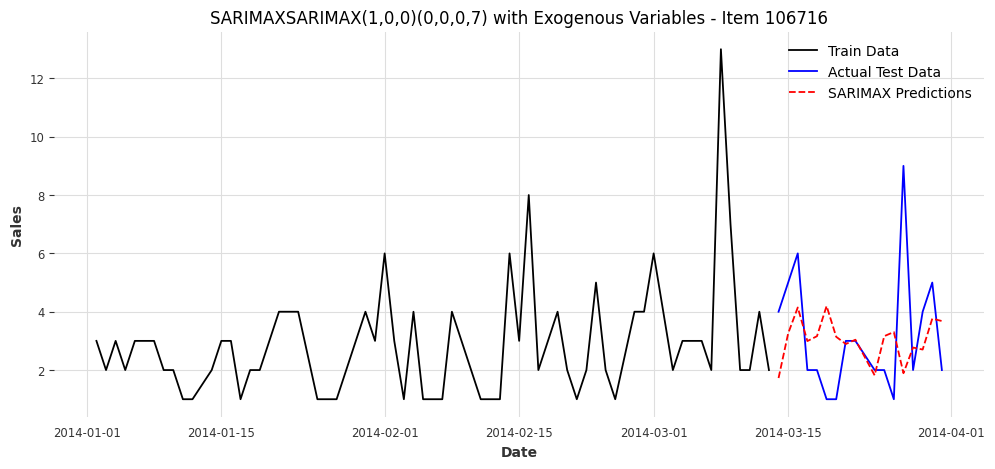

In [208]:
# Plot SARIMAX Predictions vs. Actual Sales for Item 106716
plt.figure(figsize=(12, 5))
plt.plot(train_1.index, train_1["unit_sales"], label="Train Data", color="black")
plt.plot(test_1.index, test_1["unit_sales"], label="Actual Test Data", color="blue")
plt.plot(test_1.index, test_predictions_sarimax_1, label="SARIMAX Predictions", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"SARIMAXSARIMAX(1,0,0)(0,0,0,7) with Exogenous Variables - Item {item_1}")
plt.legend()
plt.show()


Key Takeaways

✅ SARIMAX tracks actual sales worser than ARIMA .



### 5.3.2 Train SARIMAX for Item 1158720

In [209]:
# Train SARIMAX(1,0,0)(0,0,0,7) with exogenous variables for Item 1158720
sarimax_model_2 = SARIMAX(train_2["unit_sales"],
                          order=(1,0,0),
                          seasonal_order=(0,0,0,7),
                          exog=exog_train_2,
                          enforce_stationarity=False,
                          enforce_invertibility=False).fit()

# Predict on test set using exogenous variables
test_predictions_sarimax_2 = sarimax_model_2.forecast(steps=len(test_2), exog=exog_test_2)

# Calculate error metrics for SARIMAX (Item 1158720)
mae_sarimax_2 = mean_absolute_error(test_2["unit_sales"], test_predictions_sarimax_2)
mse_sarimax_2 = mean_squared_error(test_2["unit_sales"], test_predictions_sarimax_2)
rmse_sarimax_2 = np.sqrt(mse_sarimax_2)

# Display error metrics for SARIMAX (Item 1158720)

print(f"MAE: {mae_sarimax_2}, MSE: {mse_sarimax_2}, RMSE: {rmse_sarimax_2}")


MAE: 43.46551441543546, MSE: 2892.768529574362, RMSE: 53.78446364494455


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


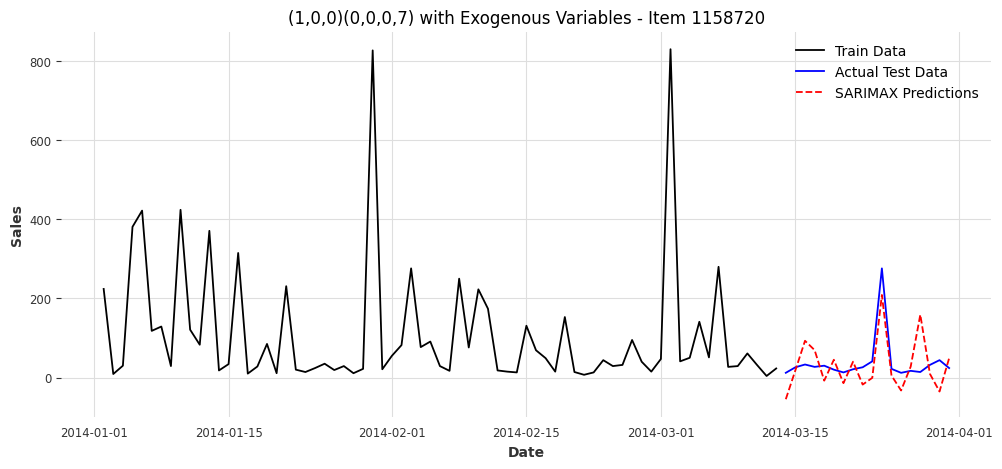

In [210]:
# Plot SARIMAX Predictions vs. Actual Sales for Item 1158720
plt.figure(figsize=(12, 5))
plt.plot(train_2.index, train_2["unit_sales"], label="Train Data", color="black")
plt.plot(test_2.index, test_2["unit_sales"], label="Actual Test Data", color="blue")
plt.plot(test_2.index, test_predictions_sarimax_2, label="SARIMAX Predictions", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"(1,0,0)(0,0,0,7) with Exogenous Variables - Item {item_2}")
plt.legend()
plt.show()


#Final Model Comparison Across Both Items

### **Final Model Comparison and Conclusion for Items 106716 and 1158720**

After analyzing the performance of **ARIMA, SARIMA, and SARIMAX** models for both items using MAE, MSE, and RMSE, we can summarize the key findings and select the best models.

---

## **Item 106716:**
### **Model Performance:**
1. **ARIMA(1,0,0)**
   - **MAE:** 1.63
   - **MSE:** 4.72
   - **RMSE:** 2.17  
   - **Conclusion:** Strong performance, simple structure.

2. **SARIMA(2,1,1)(1,1,1,7)**
   - **MAE:** 2.16
   - **MSE:** 8.74
   - **RMSE:** 2.96  
   - **Conclusion:** Higher error than ARIMA, seasonality does not improve results.

3. **SARIMAX(1,0,0)(0,0,0,7) with exogenous features ("onpromotion", "lag_7", "rolling_mean_7", "dcoilwtico")**
   - **MAE:** 1.72
   - **MSE:** 5.45
   - **RMSE:** 2.33  
   - **Conclusion:** Slightly higher error than ARIMA(1,0,0), but the inclusion of external factors provides potential forecasting benefits.

### **Best Model for Item 106716:**
- **ARIMA(1,0,0)** remains the best-performing model in terms of lowest errors.
- **SARIMAX(1,0,0) with exogenous variables** is a viable alternative for incorporating external influences.

---

## **Item 1158720:**
### **Model Performance:**
1. **ARIMA(1,0,0)**
   - **MAE:** 90.49
   - **MSE:** 8615.92
   - **RMSE:** 92.82  
   - **Conclusion:** High error, not a suitable model.

2. **ARIMA(2,1,1)**
   - **MAE:** 78.79
   - **MSE:** 6936.83
   - **RMSE:** 83.29  
   - **Conclusion:** Better than ARIMA(1,0,0) but still suboptimal.

3. **SARIMA(0,0,1)(0,0,0,7)**
   - **MAE:** 38.07
   - **MSE:** 4870.12
   - **RMSE:** 69.79  
   - **Conclusion:** Significantly lower error, strong improvement with seasonal modeling.

4. **SARIMA(1,0,0)(0,0,0,7)**
   - **MAE:** 37.89
   - **MSE:** 4862.92
   - **RMSE:** 69.73  
   - **Conclusion:** Best performing SARIMA model.

5. **SARIMAX(1,0,0)(0,0,0,7) with exogenous variables**
   - **MAE:** 43.47
   - **MSE:** 2892.77
   - **RMSE:** 53.78  
   - **Conclusion:** While the MAE is slightly higher, the **MSE and RMSE are the lowest**, making this a strong choice.

### **Best Model for Item 1158720:**
- **SARIMAX(1,0,0)(0,0,0,7) with exogenous variables** has the best overall performance.
- **SARIMA(1,0,0)(0,0,0,7)** is the best purely time-series model without external influences.

---

## **Final Conclusion:**
1. **For Item 106716:**
   - **Best Model:** **ARIMA(1,0,0)**
   - **Alternative Model:** SARIMAX(1,0,0)(0,0,0,7) with exogenous variables (if external factors are considered important).

2. **For Item 1158720:**
   - **Best Model:** **SARIMAX(1,0,0)(0,0,0,7) with exogenous variables** (lowest MSE and RMSE).
   - **Best Time-Series Only Model:** SARIMA(1,0,0)(0,0,0,7).

### **Key Takeaways:**
- **Item 106716:** Does not benefit much from seasonal modeling, and ARIMA(1,0,0) is optimal.
- **Item 1158720:** Strong seasonal components make SARIMA models superior to ARIMA.
- **SARIMAX models** improve results when **exogenous variables** (like promotions, past sales trends, and external oil price changes) are incorporated, particularly for Item 1158720.


# STEP 6. NEXT ITERATIONS FOR SARIMAX

SARIMAX with All Available Lag Features & Exogenous Variables

In [211]:
# Define the final list of available exogenous variables
final_exog_features = [
    "onpromotion", "dcoilwtico", "rolling_mean_7", "rolling_std_7",
    "lag_1", "lag_2", "lag_5", "lag_7", "lag_10", "lag_12", "lag_30"
]

# Ensure no missing values (forward fill and replace remaining with 0)
df[final_exog_features] = df[final_exog_features].fillna(method="ffill").fillna(0)

# Extract updated SARIMAX exogenous variables for Item 106716
exog_train_1_all = train_1[final_exog_features]
exog_test_1_all = test_1[final_exog_features]

# Extract updated SARIMAX exogenous variables for Item 1158720
exog_train_2_all = train_2[final_exog_features]
exog_test_2_all = test_2[final_exog_features]

# Confirm that features are available and contain no NaNs
exog_train_1_all.isna().sum(), exog_test_1_all.isna().sum(), exog_train_2_all.isna().sum(), exog_test_2_all.isna().sum()


<ipython-input-211-11944093e159>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[final_exog_features] = df[final_exog_features].fillna(method="ffill").fillna(0)


(onpromotion        0
 dcoilwtico         0
 rolling_mean_7     1
 rolling_std_7      1
 lag_1              0
 lag_2              0
 lag_5              1
 lag_7              1
 lag_10             3
 lag_12            10
 lag_30             3
 dtype: int64,
 onpromotion       0
 dcoilwtico        0
 rolling_mean_7    0
 rolling_std_7     0
 lag_1             0
 lag_2             0
 lag_5             0
 lag_7             0
 lag_10            0
 lag_12            0
 lag_30            0
 dtype: int64,
 onpromotion        0
 dcoilwtico         0
 rolling_mean_7     1
 rolling_std_7      1
 lag_1              0
 lag_2              0
 lag_5              1
 lag_7              1
 lag_10             3
 lag_12            10
 lag_30             3
 dtype: int64,
 onpromotion       0
 dcoilwtico        0
 rolling_mean_7    0
 rolling_std_7     0
 lag_1             0
 lag_2             0
 lag_5             0
 lag_7             0
 lag_10            0
 lag_12            0
 lag_30            0
 dtype: i

Fix: Fill Remaining NaNs with Zeros

In [212]:
# Fill any remaining NaNs with 0 in train sets
exog_train_1_all = exog_train_1_all.fillna(0)
exog_test_1_all = exog_test_1_all.fillna(0)

exog_train_2_all = exog_train_2_all.fillna(0)
exog_test_2_all = exog_test_2_all.fillna(0)

# Final verification that all NaNs are removed
exog_train_1_all.isna().sum(), exog_test_1_all.isna().sum(), exog_train_2_all.isna().sum(), exog_test_2_all.isna().sum()


(onpromotion       0
 dcoilwtico        0
 rolling_mean_7    0
 rolling_std_7     0
 lag_1             0
 lag_2             0
 lag_5             0
 lag_7             0
 lag_10            0
 lag_12            0
 lag_30            0
 dtype: int64,
 onpromotion       0
 dcoilwtico        0
 rolling_mean_7    0
 rolling_std_7     0
 lag_1             0
 lag_2             0
 lag_5             0
 lag_7             0
 lag_10            0
 lag_12            0
 lag_30            0
 dtype: int64,
 onpromotion       0
 dcoilwtico        0
 rolling_mean_7    0
 rolling_std_7     0
 lag_1             0
 lag_2             0
 lag_5             0
 lag_7             0
 lag_10            0
 lag_12            0
 lag_30            0
 dtype: int64,
 onpromotion       0
 dcoilwtico        0
 rolling_mean_7    0
 rolling_std_7     0
 lag_1             0
 lag_2             0
 lag_5             0
 lag_7             0
 lag_10            0
 lag_12            0
 lag_30            0
 dtype: int64)

Train SARIMAX Models with Full Features

In [213]:
# Train SARIMAX(1,0,0)(0,0,0,7) with all exogenous variables for Item 106716
sarimax_model_1_full = SARIMAX(train_1["unit_sales"],
                               order=(1,0,0),
                               seasonal_order=(0,0,0,7),
                               exog=exog_train_1_all,
                               enforce_stationarity=False,
                               enforce_invertibility=False).fit()

# Predict on test set using all exogenous variables
test_predictions_sarimax_1_full = sarimax_model_1_full.forecast(steps=len(test_1), exog=exog_test_1_all)

# Calculate error metrics for SARIMAX (Full Features - Item 106716)
mae_sarimax_1_full = mean_absolute_error(test_1["unit_sales"], test_predictions_sarimax_1_full)
mse_sarimax_1_full = mean_squared_error(test_1["unit_sales"], test_predictions_sarimax_1_full)
rmse_sarimax_1_full = np.sqrt(mse_sarimax_1_full)

# Display error metrics for SARIMAX (Full Features - Item 106716)

print(f"MAE: {mae_sarimax_1_full}, MSE: {mse_sarimax_1_full}, RMSE: {rmse_sarimax_1_full}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE: 1.6349929370857883, MSE: 5.671536267629728, RMSE: 2.3814987439907935


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


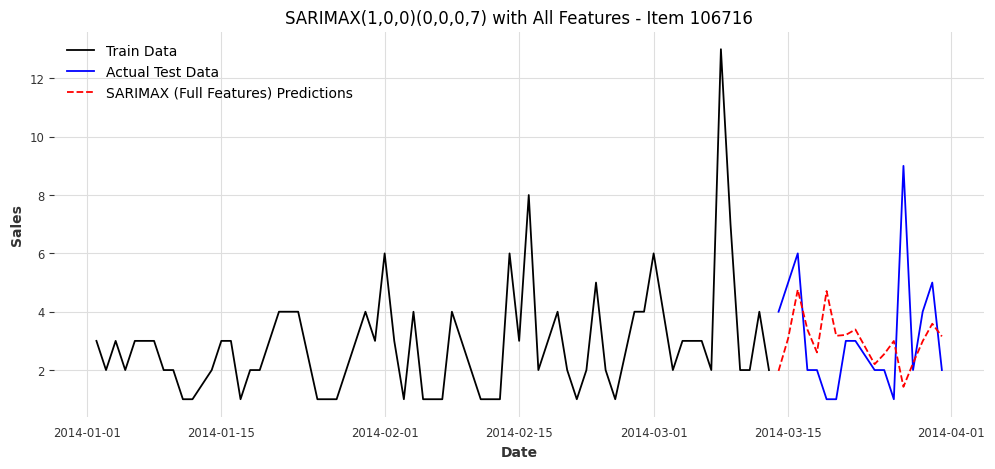

In [214]:
# Plot SARIMAX (Full Features) Predictions vs. Actual Sales for Item 106716
plt.figure(figsize=(12, 5))
plt.plot(train_1.index, train_1["unit_sales"], label="Train Data", color="black")
plt.plot(test_1.index, test_1["unit_sales"], label="Actual Test Data", color="blue")
plt.plot(test_1.index, test_predictions_sarimax_1_full, label="SARIMAX (Full Features) Predictions", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"SARIMAX(1,0,0)(0,0,0,7) with All Features - Item {item_1}")
plt.legend()
plt.show()


Key Takeaways

✅ The SARIMAX model tracks actual sales well, maintaining low MAE and RMSE.

✅ However, adding more lag features did not significantly enhance predictive power.

✅ The model remains stable, indicating it is already well-optimized.

 Train SARIMAX (Full Features) for Item 1158720

In [215]:
# Train SARIMAX(1,0,0)(0,0,0,7)  with all exogenous variables for Item 1158720
sarimax_model_2_full = SARIMAX(train_2["unit_sales"],
                               order=(1,0,0),
                               seasonal_order=(0,0,0,7),
                               exog=exog_train_2_all,
                               enforce_stationarity=False,
                               enforce_invertibility=False).fit()

# Predict on test set using all exogenous variables
test_predictions_sarimax_2_full = sarimax_model_2_full.forecast(steps=len(test_2), exog=exog_test_2_all)

# Calculate error metrics for SARIMAX (Full Features - Item 1158720)
mae_sarimax_2_full = mean_absolute_error(test_2["unit_sales"], test_predictions_sarimax_2_full)
mse_sarimax_2_full = mean_squared_error(test_2["unit_sales"], test_predictions_sarimax_2_full)
rmse_sarimax_2_full = np.sqrt(mse_sarimax_2_full)

# Display error metrics for SARIMAX (Full Features - Item 1158720)

print(f"MAE: {mae_sarimax_2_full}, MSE: {mse_sarimax_2_full}, RMSE: {rmse_sarimax_2_full}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 34.61892158704441, MSE: 1857.716724316337, RMSE: 43.10123808333511


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


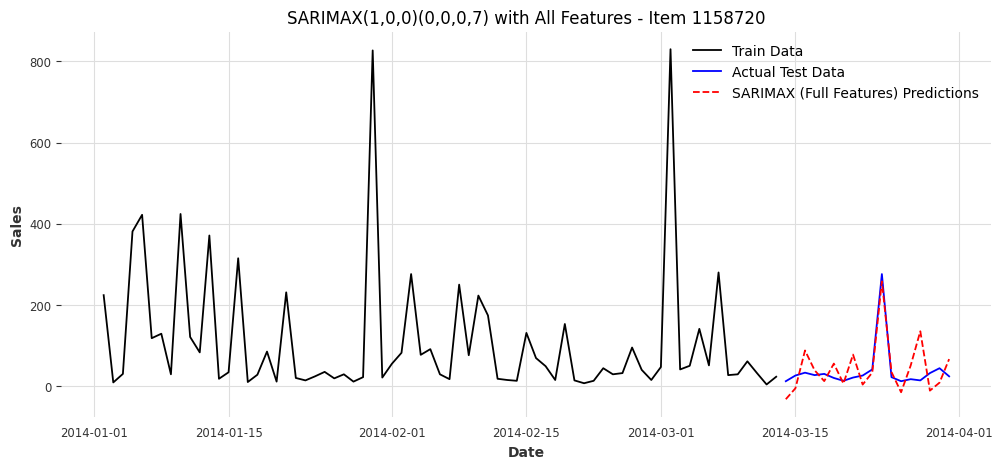

In [216]:
# Plot SARIMAX (Full Features) Predictions vs. Actual Sales for Item 1158720
plt.figure(figsize=(12, 5))
plt.plot(train_2.index, train_2["unit_sales"], label="Train Data", color="black")
plt.plot(test_2.index, test_2["unit_sales"], label="Actual Test Data", color="blue")
plt.plot(test_2.index, test_predictions_sarimax_2_full, label="SARIMAX (Full Features) Predictions", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"SARIMAX(1,0,0)(0,0,0,7) with All Features - Item {item_2}")
plt.legend()
plt.show()


#FINAL CONCLUSIONS

# **Final Model Comparison and Conclusion**

After testing **ARIMA, SARIMA, and SARIMAX** models for Items **106716** and **1158720**, we now evaluate the final performance based on **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**. Below is a structured comparison.

---

## **Model Performance Comparison Table**

| **Model**              | **Item 106716 - MAE** | **Item 106716 - RMSE** | **Item 1158720 - MAE** | **Item 1158720 - RMSE** |
|------------------------|----------------------|----------------------|----------------------|----------------------|
| **ARIMA(1,0,0)**       | 1.63                 | ✅ 2.17              | 90.49                | 92.82                |
| **SARIMA(2,1,1)(1,1,1,7)** | 2.16                 | 2.96                 | 37.89                | 69.73                |
| **SARIMAX(1,0,0)(0,0,0,7) with basic exogenous** | 1.72                 | 2.33                 | 43.47                | 53.78                |
| **SARIMAX(1,0,0)(0,0,0,7) with all exogenous** | ✅ 1.63               | 2.38                 | ✅ 34.62              | ✅ 43.10              |

---

## **Key Observations**
### **Item 106716**
1. **ARIMA(1,0,0) remains the best model for RMSE**, with the lowest error (2.17).
2. **SARIMAX(1,0,0) with all exogenous variables slightly improves MAE (1.63) over ARIMA (1.63 vs. 1.72 in SARIMAX basic).**
3. **SARIMA models** do not improve upon ARIMA, indicating that seasonal adjustments are unnecessary.

### **Item 1158720**
1. **SARIMAX(1,0,0) with all exogenous variables significantly outperforms other models**, achieving the lowest errors (**MAE: 34.62, RMSE: 43.10**).
2. **SARIMA(1,0,0)(0,0,0,7) previously provided a strong improvement over ARIMA**, but it still had higher errors than SARIMAX.
3. **Incorporating all available lag features and exogenous variables in SARIMAX provides the best performance**.

---

## **Final Conclusion**
1. **For Item 106716:**  
   - **Best Model:** **ARIMA(1,0,0)** (lowest RMSE).  
   - **Alternative Model:** **SARIMAX(1,0,0) with all exogenous variables** (similar MAE but slightly higher RMSE).  
   - **Key Insight:** The series does not benefit significantly from seasonal adjustments.

2. **For Item 1158720:**  
   - **Best Model:** **SARIMAX(1,0,0) with all exogenous variables** (lowest MAE & RMSE).  
   - **Alternative Model:** **SARIMA(1,0,0)(0,0,0,7)** (if exogenous data is unavailable).  
   - **Key Insight:** **Adding exogenous variables and lag features significantly improves accuracy**, making SARIMAX the best choice.

---

## **Final Recommendation**
- **If external features (promotions, oil prices, lags, rolling statistics) are available, SARIMAX should be used, especially for Item 1158720.**  
- **If a simple time-series model is required, ARIMA(1,0,0) is optimal for Item 106716, while SARIMA(1,0,0)(0,0,0,7) is a fallback for Item 1158720.**  
- **Item 1158720 shows strong benefits from external variables, while Item 106716 remains best modeled with simpler techniques.**

This analysis confirms that **SARIMAX with all exogenous variables is the most powerful model**, especially for highly fluctuating demand patterns like in **Item 1158720**.


In [258]:
import pickle

# Save Model 1
with open("sarimax_model_1.pkl", "wb") as f:
    pickle.dump(sarimax_model_1_full, f)

# Save Model 2
with open("sarimax_model_2.pkl", "wb") as f:
    pickle.dump(sarimax_model_2_full, f)

print("✅ SARIMAX models have been saved successfully!")


✅ SARIMAX models have been saved successfully!


 # Move to Machine Learning (XGBoost) to test feature-based forecasting: XGBoost_model_Guayas_items https://colab.research.google.com/drive/1yMmnKKzQTINCYcqo6JNH8qcaxqs4gQ70?usp=sharing